In [49]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [105]:
m= np.array([[-1.00080059, 0.00506476, 0.01086024],
 [-0.00435842, 0.03755458, -0.99129955],
 [-0.03711249, -0.8929882, -0.01908519]])
v=np.array([ 22.46134747, 92.83427267, 213.57909233]*10) # times 10 to get it in mm
def AM(alpha):
    return np.array([[np.cos(alpha), -np.sin(alpha),0],
                    [np.sin(alpha), np.cos(alpha),0],
                    [0, 0, 1]])
def AMT(alpha):
    return np.transpose(AM(alpha))

def BM(beta):
    return np.array([[1, 0, 0],
                    [0, np.cos(beta), -np.sin(beta)],
                    [0, np.sin(beta), np.cos(beta)]])
def BMT(beta):
    return np.transpose(BM(beta))
        
def CM(gamma):
    return np.array([[np.cos(gamma), -np.sin(gamma),0],
                    [np.sin(gamma), np.cos(gamma),0],
                    [0, 0, 1]])
def CMT(gamma):
    return np.transpose(CM(gamma))

The idea is to factorize the matrix $M$ obtained by the general fitting procedure into a rotation matrix and a "residual matrix" L like so:
$$
M= L\cdot C(\gamma)\cdot B(\beta) \cdot A(\alpha)
$$
where $\alpha$, $\beta$, $\gamma$ are appropriate Euler angles.

To obtain $\alpha$, $\beta$, $\gamma$ we simply minimize the norm of the difference 
$$
\hat{L}-\mathbf{1}
$$
where
$$
\hat{L}= M\cdot A^{-1}(\alpha) \cdot B^{-1}(\beta) \cdot C^{-1}(\gamma)
$$
using $A^{-1}=A^T$ and so on.

In [106]:
def residual_matrix(x,m):
    return np.dot(m,np.dot(np.dot(AMT(x[0]),BMT(x[1])),CMT(x[2])))
def the_matrix(x):
    return np.dot(np.dot(CM(x[2]),BM(x[1])),AM(x[0]))
    
def err_fun(x,m):
    L= residual_matrix(x,m)
    error= np.linalg.norm((L-np.identity(3)))
    return error

x= np.array([3.14, 1.55, 0]) # guessed Euler angles
result = minimize(err_fun, x, args=(m), method='nelder-mead', options={'disp': True,'maxiter':10000,'maxfev':20000})
xn = result['x']
print(xn)
print(err_fun(xn,m))

Optimization terminated successfully.
         Current function value: 0.109864
         Iterations: 81
         Function evaluations: 143
[3.16411702 1.60085007 0.008335  ]
0.1098641887862471


xn contains the Euler angles of the fitted rotation matrix. It compares well with the Euler angles obtained in the calibration with the rotation+translation approach:

In [112]:
yn= [3.15130498, 1.61601099, 0.01014881]
print(xn)
print(yn)
print(f'difference: {xn-yn}')

[3.16411702 1.60085007 0.008335  ]
[3.15130498, 1.61601099, 0.01014881]
difference: [ 0.01281204 -0.01516092 -0.00181381]


Let's now examine the "residual matrix" L, i.e. the additional transformation besides the rotation that M performs. For comparison, let's look at the residual matrix for the rotation fitted here and for the rotation from the rotation+translation approach.

In [113]:
print(residual_matrix(xn,m))
print(residual_matrix(yn,m))

[[ 1.00072089 -0.0030397   0.01714279]
 [-0.00306508  0.99198606 -0.00764221]
 [ 0.017055   -0.00763345  0.89376751]]
[[ 1.00086328e+00 -9.02212232e-04  4.15979538e-03]
 [-5.34455498e-03  9.91978725e-01  7.33386201e-03]
 [ 2.86526972e-02 -2.10214050e-02  8.93256195e-01]]


In both cases, the matrix is essentially the unity matrix *except* for the (3,3) component, which is approximately 0.89. So, the residual matrix implements a rescaling operation on the z axis after rotation. 

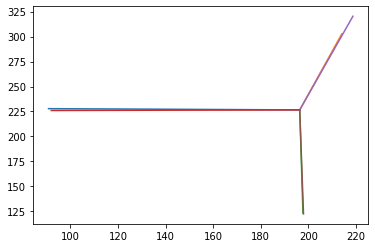

In [110]:
def vicon_to_dv(m, v):
    z= vicon_to_camera_centric(m,v)
    z *= (1.0 / z[2])*4  # focal length 4 mm
    z= z[:2]
    z/= 1.8e-2   # 18 micrometer/pixel = 1.8e-2 mm/pixel
    z+= [173, 130]  # add the origin offset from image centre to top left corner explicitly
    return z

def vicon_to_camera_centric(m, v):
    M= np.reshape(m[:9],(3,3))
    z = np.dot(M,v) # apply the rotation to get into the camera orientation frame
    z += m[9:12]*10  # add the translation (using cm for a better scale of fitting)
    return z
    
x1= np.hstack((m.flatten(),v))  
x2= np.hstack((the_matrix(yn).flatten(),v))

def plot_ax(m):
    ax= np.array([[[ 0, 0, 0], [1000, 0, 0]],
         [[ 0, 0, 0], [0, 1000, 0]],
         [[ 0, 0, 0], [0, 0, 1000]]])
    ax2= np.empty((3,2,2))
    for i in range(3):
        for j in range(2):
            ax2[i,j,:]= vicon_to_dv(m,ax[i,j,:])
    for i in range(3):
        plt.plot(ax2[i,:,0].flatten(),ax2[i,:,1].flatten())

plt.figure()
plot_ax(x1)
plot_ax(x2)